# Apply HUX Mapping Technique to in-situ spacecraft observations


In [1]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy import interpolate
import numpy as np
import scipy
import copy
import pickle
import math
import os
import datetime as dt 

from heliopy.data import omni
from heliopy.data import solo
import heliopy.data.spice as spicedata
import heliopy.spice as spice
from astropy.coordinates import SkyCoord
import astropy.units as u

from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable

from code.archimedes_sprial import cmap_spiral, compute_phi_shift_forward
from code.hux_propagation import *
from code.carrington_dates import * 

# matplotlib fontsize
%matplotlib notebook
%matplotlib inline
fs1=12
plt.rcParams['savefig.facecolor'] = 'white'

# Read in global MHD model (MAS) solutions 

#### Time intervals where SolO SWA $V_{r}$ data is available. 

CR 2236	|| 2020 Oct 05	-> 2020 Nov 01

CR 2235 || 2020 Sep 07	-> 2020 Oct 05	

CR 2234	|| 2020 Aug 11	-> 2020 Sep 07	

CR 2233	|| 2020 Jul 15	-> 2020 Aug 11	

CR 2232	|| 2020 Jun 18	-> 2020 Jul 15 (nearly no data for SOLO)

#### Earth and SolO minimum latitude difference (optimal alignment): '2020-07-07T20:00:00.000000' CR2233 and CR2232

Download MAS solutions from [Predictive Science Inc. website](http://www.predsci.com/data/runs).

For more information about reading MHD solutions see [PsiPy documentation website](https://psipy.readthedocs.io/en/stable/guide/getting_started.html#getting-data).

In [2]:
case_study = "cr2233"
starttime, endtime, cr = get_time_interval(case_study)

In [3]:
# create directory to save figures
try:
    os.mkdir("figures/solo/" + case_study + "/")
except OSError as error:
    print(error)

[WinError 183] Cannot create a file when that file already exists: 'figures/solo/cr2233/'


In [4]:
# mas output - br, rho, vr
mas_path = get_mas_path(cr=cr)

model = MASOutput(mas_path)

print(model.variables)

['br', 'rho', 'vr']


In [5]:
# read in MHD velocity results. 
vr_model = model['vr']

In [6]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
r = vr_model.r_coords
# velocity profile 
f = vr_model.data

In [7]:
print("Velocity matrix shape: ", np.shape(f))
print("Phi dim: ", np.shape(f)[0])
print("Theta dim: ", np.shape(f)[1])
print("Radial dim: ", np.shape(f)[2])
print("Velocity matrix dtype: ", f.dtype)


Velocity matrix shape:  (128, 111, 140)
Phi dim:  128
Theta dim:  111
Radial dim:  140
Velocity matrix dtype:  float32


In [8]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p_plot = np.append(p, 2*np.pi) 

# Phi: from radians to degrees. longitude.
p_plot = (180/np.pi)*p_plot

In [9]:
# append the first slice p=0 to velocity matrix. 
f_plot = np.append(f,[f[0,:, :]],axis=0)

In [10]:
# Radius: from solar radii to km. 
# 1 solar radii = 695,700 km
r_plot = (695700)*r

In [11]:
# convert to sin(Lat.) [-1, 1]
t_plot = np.sin(t)

In [12]:
# NOTE: pcolorfast and pcolormesh want the coords of pixel corners not centers --> build a "half mesh" for p & t.
# - This means making an array that is n+1 size and has the midpoint positions of the original.
# - Here we clip the endpoints of the half mesh to the original bounds, vs extrapolate.
# - see also https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html.

cmap = 'gnuplot'

ph = np.concatenate([[p_plot[0]], 0.5 * (p_plot[1:] + p_plot[:-1]), [p_plot[-1]]])
th = np.concatenate([[t_plot[0]], 0.5 * (t_plot[1:] + t_plot[:-1]), [t_plot[-1]]])

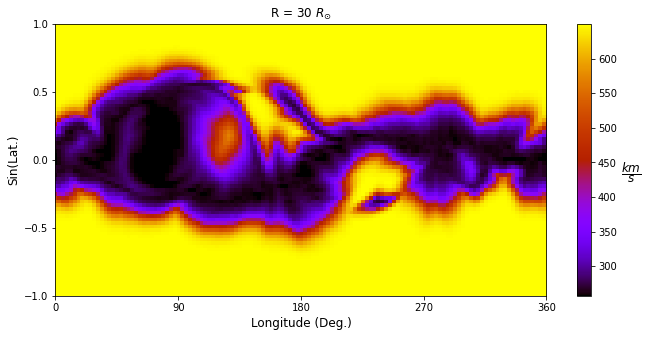

In [13]:
fig, ax = plt.subplots(figsize = (11,5))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 30 $R_{\odot}$", fontsize=fs1)
ax.set_ylabel("Sin(Lat.)", fontsize=fs1)
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, f_plot[:, :, 0].T, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)
#plt.savefig('figures/solo/' + case_study + '/vr_30rs_map.png')

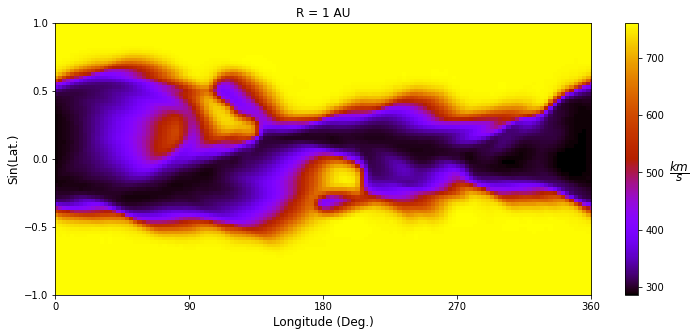

In [14]:
fig, ax = plt.subplots(figsize = (12,5))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 1 AU", fontsize=fs1)
ax.set_ylabel("Sin(Lat.)", fontsize=fs1)
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, f_plot[:, :, -1].T, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)
#plt.savefig('figures/solo/' + case_study + '/vr_1au_map.png')

# Apply Heliospheric Upwind eXtrapolation method 

The HUX underlying PDE (Simplified fluid momentum equation in a corotating frame of reference):

$$
-\Omega_{rot}\frac{\partial v_{r}}{\partial \phi} + v_{r}\frac{ \partial v_{r}}{\partial r}=0
$$

With the initial condition 
$$
v_{r}(\phi, r_{0}) = v_{r0}(\phi)
$$

The HUX-f technique leverages the forward upwind difference method, such that
$$
-\Omega_{rot} \frac{v_{i, j+1} - v_{i, j}}{\Delta \phi} + 
v_{i, j}(\frac{v_{i+1, j} - v_{i, j}}{\Delta r}) = 0
$$


$$
v_{i+1, j}=  v_{i, j} + \frac{\Delta r\Omega_{rot}}{v_{i, j}}  (\frac{v_{i, j+1} - v_{i, j}}{\Delta \phi})
$$

Whereas HUX-b technique leverages the backwards finite difference approximation, such that 

$$
-\Omega_{rot} \frac{v_{i, j} - v_{i, j-1}}{\Delta \phi} + 
v_{i, j}(\frac{v_{i, j} - v_{i-1, j}}{\Delta r}) = 0
$$


$$
v_{i-1, j}=  v_{i, j} + \frac{\Delta r\Omega_{rot}}{v_{i, j}}  (\frac{v_{i, j}-v_{i, j-1}}{\Delta \phi})
$$

where for simplicity the $r$ subscipt on the radial velocity is omitted. The indicies $i$ and $j$ refer to $r$ and $\phi$ grids repectively in HG coordinates. 



# References

[1] Riley P and Lionello R (2011) "Mapping Solar Wind Streams from the Sun to 1 AU: A Comparison of Techniques". Solar Phys.270, 575–592. 

[2] Riley P and Issan O (2021) "Using a Heliospheric Upwinding eXtrapolation Technique to Magnetically Connect Different Regions of the Heliosphere". Front. Phys. 9:679497.

In [15]:
# get solar equator slices and save delta r and delta p arrays for hux propagation. 
solar_equator_r_30_radii = f[:, 55, 0]
solar_equator_r_1_au = f[:, 55, -1]
dr_vec = r_plot[1:] - r_plot[:-1]
dp_vec = p[1:] - p[:-1]

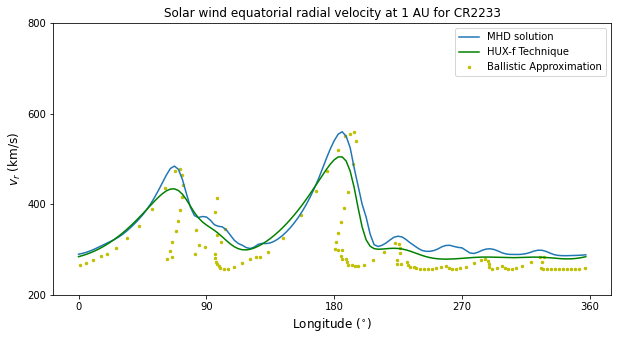

In [16]:
fig, ax = plt.subplots(figsize = (10,5))

_ = ax.plot(p*180/np.pi, solar_equator_r_1_au, label="MHD solution")
_ = ax.plot(p*180/np.pi, apply_forward_upwind_model(solar_equator_r_30_radii, dr_vec, dp_vec),
            'g',label="HUX-f Technique")

_ = ax.scatter(apply_ballistic_approximation(np.array(solar_equator_r_30_radii), 
                r_plot[-1] - r_plot[0], p)*180/np.pi, 
                solar_equator_r_30_radii, 
                color='y',s = 6, label="Ballistic Approximation")
            
_ = ax.set_title("Solar wind equatorial radial velocity at 1 AU for CR" + str(cr) ,fontsize=fs1)
_ = ax.set_xlabel("Longitude ($^{\circ}$)",fontsize=fs1)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])

_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_ylabel('$v_{r}$ (km/s)',fontsize=fs1)
_ = plt.legend()
plt.savefig('figures/solo/' + case_study + '/vr_1AU_ts_comp_MHD_HUX-f.png')

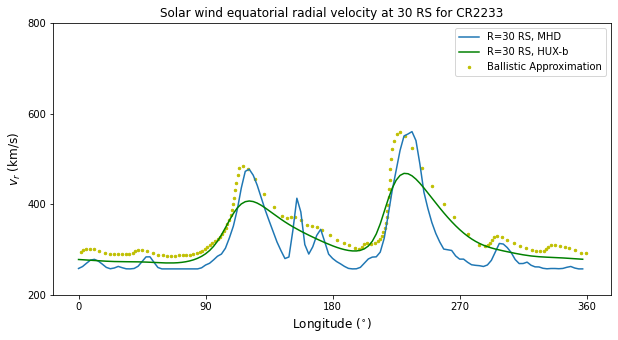

In [17]:
fig, ax = plt.subplots(figsize = (10,5))

_ = ax.plot(p*180/np.pi, solar_equator_r_30_radii , label="R=30 RS, MHD")
_ = ax.plot(p*180/np.pi, apply_backwards_upwind_model(solar_equator_r_1_au, dr_vec, dp_vec),
            'g',label="R=30 RS, HUX-b")


_ = ax.scatter(apply_ballistic_approximation(np.array(solar_equator_r_1_au), 
                r_plot[0]- r_plot[-1], p)*180/np.pi, 
                solar_equator_r_1_au, 
                color='y',s=6, label="Ballistic Approximation")

_ = ax.set_title("Solar wind equatorial radial velocity at 30 RS for CR" + str(cr),fontsize=fs1)
_ = ax.set_xlabel("Longitude ($^{\circ}$)",fontsize=fs1)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_ylabel('$v_{r}$ (km/s)',fontsize=fs1)
_ = plt.legend()
plt.savefig('figures/solo/' + case_study + '/vr_30RS_ts_comp_MHD_HUX-b_cr' + str(cr) +'.png')

In [18]:
# apply the hux technique to all theta slices
hux_f_res, hux_b_res = np.ones((len(p), len(t), len(r))),  np.ones((len(p), len(t), len(r)))
for ii in range(len(t)):
    hux_f_res[:, ii, :] = apply_hux_f_model(f[:, ii, 0], dr_vec, dp_vec).T
    hux_b_res[:, ii, :] = apply_hux_b_model(f[:, ii, -1], dr_vec, dp_vec).T

In [19]:
# force periodicity when plotting
hux_f_res_plot = np.append(hux_f_res,[hux_f_res[0, :, :]], axis=0)
hux_b_res_plot = np.append(hux_b_res,[hux_b_res[0, :, :]], axis=0)

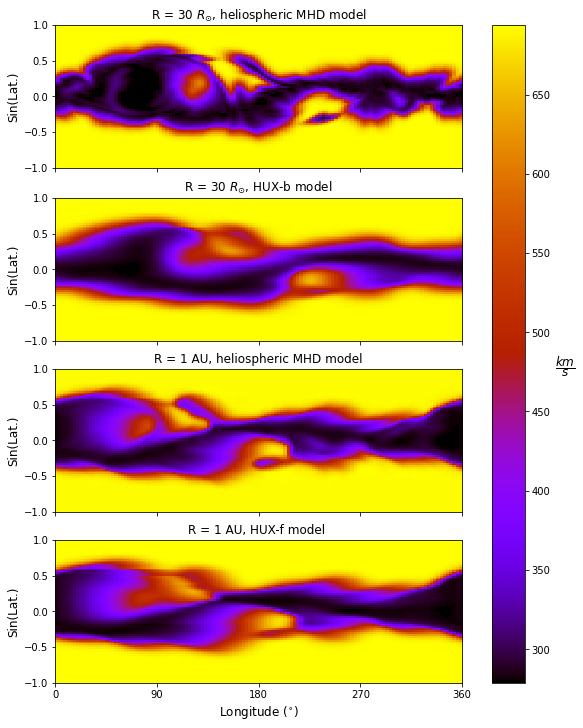

In [20]:
plt.rcParams['figure.figsize'] = [8, 10] # default fig size.

fig, ax = plt.subplots(nrows=4, ncols=1, constrained_layout=True, sharex=True)

ax[0].set_ylim(-1, 1)
ax[0].set_xlim(0, 360)
ax[0].set_title("R = 30 $R_{\odot}$, heliospheric MHD model", fontsize=fs1)
ax[0].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[0].pcolorfast(ph, th, f_plot[:, :, 0].T, cmap=cmap)

ax[1].set_ylim(-1, 1)
ax[1].set_xlim(0, 360)
ax[1].set_title("R = 30 $R_{\odot}$, HUX-b model", fontsize=fs1)
ax[1].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[1].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[1].pcolorfast(ph, th, hux_b_res_plot[:, :, 0].T, cmap=cmap)


ax[2].set_ylim(-1, 1)
ax[2].set_xlim(0, 360)
ax[2].set_title("R = 1 AU, heliospheric MHD model", fontsize=fs1)
ax[2].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[2].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[2].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[2].pcolorfast(ph, th, f_plot[:, :, -1].T, cmap=cmap)


ax[3].set_ylim(-1, 1)
ax[3].set_xlim(0, 360)
ax[3].set_title("R = 1 AU, HUX-f model ", fontsize=fs1)
ax[3].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[3].set_xlabel("Longitude ($^{\circ}$)", fontsize=fs1)
ax[3].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[3].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[3].pcolorfast(ph, th, hux_f_res_plot[:, :, -1].T, cmap=cmap)
cbar = fig.colorbar(im, ax=ax.flat)
cbar.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)

plt.savefig('figures/solo/' + case_study + '/vr_lon_lat_maps_MHD_HUX.png')

# Read in Solar Orbiter (SolO) observations


In [21]:
# example MAG-RTN-NORMAL // SWA-EAS-SS LL02 // SWA-PAS-MOM L1
# see https://www.davidstansby.com/soda/ for dates with available data

solo_data = solo.download(starttime, endtime, 'SWA-PAS-MOM', 'L1')
print("Available data = ", solo_data.columns)

Available data =  ['CCSDS_time', 'SCET', 'sample', 'validity', 'sum_PAS', 'data_validity_flag', 'density', 'velocity_0', 'velocity_1', 'velocity_2', 'pressure_0', 'pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'temperature']


In [22]:
solo_data.data

,CCSDS_time,SCET,sample,validity,sum_PAS,data_validity_flag,density,velocity_0,velocity_1,velocity_2,pressure_0,pressure_1,pressure_2,pressure_3,pressure_4,pressure_5,temperature
Time,,,,,,,,,,,,,,,,,
2020-07-15 00:00:03.041183104,6.480865e+08,648086380.5,5,0,2,1,16.500000,411.0,66.0,25.0,3.271409e-17,3.269171e-17,3.268887e-17,1.901152e-27,3.801864e-27,2.044730e-18,12.368540
2020-07-15 00:00:07.041183104,6.480865e+08,648086384.5,6,0,2,1,16.299999,411.0,65.0,21.0,6.537206e-17,3.269273e-17,3.268931e-17,1.901260e-27,3.801980e-27,2.044626e-18,16.688786
2020-07-15 00:00:11.041183104,6.480865e+08,648086388.5,7,0,2,1,15.900000,411.0,64.0,23.0,6.536964e-17,3.269208e-17,3.268772e-17,1.901754e-27,3.801918e-27,4.085641e-18,17.108017
2020-07-15 00:00:15.041183104,6.480865e+08,648086392.5,8,0,2,1,16.000000,409.0,63.0,20.0,6.537400e-17,3.269071e-17,3.268634e-17,1.901121e-27,3.801388e-27,2.044040e-18,17.001303
2020-07-15 00:00:19.041183104,6.480865e+08,648086396.5,9,0,2,1,16.000000,409.0,63.0,21.0,6.536969e-17,3.269071e-17,3.268878e-17,1.901480e-27,3.801534e-27,2.044256e-18,17.001060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-10 07:48:46.712217088,6.503609e+08,650360900.5,21,255,255,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-10 07:48:50.712217088,6.503609e+08,650360904.5,22,255,255,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-10 07:48:54.712217088,6.503609e+08,650360908.5,23,255,255,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Generate the SolO trajectory in Heliographic (rotating) Coordinate System (HG).

We take the timestamps from the previously loaded data, and use `heliopy.spice`
to generate the trajectory at these times.

In [23]:
times = solo_data.index

orbiter_kernel = spicedata.get_kernel('solo')
spice.furnish(orbiter_kernel)
orbiter = spice.Trajectory('Solar Orbiter')

orbiter.generate_positions(times=times, observing_body='Sun', frame='IAU_SUN')
solo_coords = orbiter.coords

Here we sample the MHD and HUX velocity results at PSP location. 


In [24]:
hux_f_model = copy.deepcopy(vr_model)
hux_f_model.data.data = hux_f_res

hux_b_model = copy.deepcopy(vr_model)
hux_b_model.data.data = hux_b_res

In [25]:
vr_sampled_hux_f = hux_f_model.sample_at_coords(solo_coords.lon,
                                                solo_coords.lat,
                                                solo_coords.radius)

vr_sampled_hux_b = hux_b_model.sample_at_coords(solo_coords.lon,
                                                solo_coords.lat,
                                                solo_coords.radius)

vr_sampled_mhd = vr_model.sample_at_coords(solo_coords.lon,
                                           solo_coords.lat,
                                           solo_coords.radius)

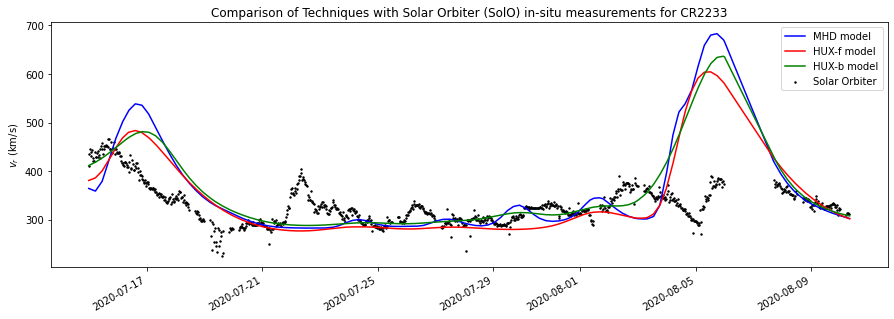

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(times, vr_sampled_mhd, color="b", label='MHD model')
ax.plot(times, vr_sampled_hux_f, color="r",label='HUX-f model')
ax.plot(times, vr_sampled_hux_b, color="g",label='HUX-b model')
ax.scatter(times[::500], solo_data.quantity('velocity_0')[::500], color="k", s=2, label='Solar Orbiter')

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.legend()
ax.set_title("Comparison of Techniques with Solar Orbiter (SolO) in-situ measurements for CR" + str(cr))
fig.autofmt_xdate()

plt.savefig('figures/solo/'+ case_study + '/solo_comparison_cr'+ str(cr)+ '_time.png')

182314


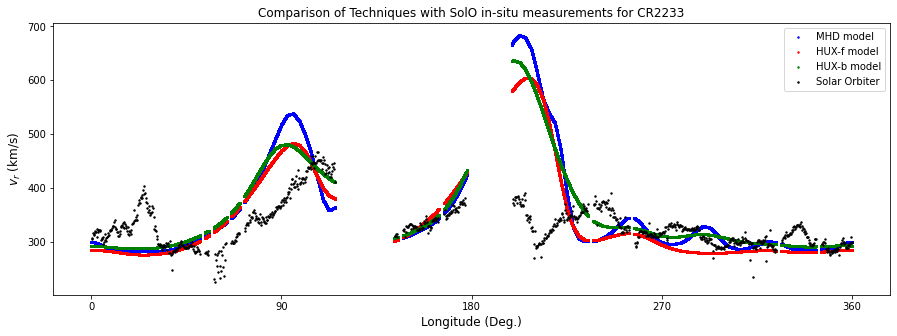

In [27]:
lon_solo = np.array(solo_coords.lon)

max_indx=np.argmax(solo_coords.lon)
print(max_indx)
add_periodicity =0

fig, ax = plt.subplots(figsize=(15, 5))
size = 2

ax.scatter(lon_solo, vr_sampled_mhd, color="b", s=size, label="MHD model")
ax.scatter(lon_solo, vr_sampled_hux_f, color="r", s=size, label="HUX-f model")
ax.scatter(lon_solo, vr_sampled_hux_b, color="g",s=size,  label="HUX-b model")
ax.scatter(lon_solo[::500], solo_data.quantity('velocity_0')[::500], color="k", s=size, label="Solar Orbiter")


ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_title("Comparison of Techniques with SolO in-situ measurements for CR" + str(cr))
ax.legend()
plt.savefig('figures/solo/'+ case_study + '/solo_comparison_cr' + str(cr) + '_carrington_longitude.png')

# Read in OMNI (Earth) Observations

• OMNI data set for solar wind speed observations can be found https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/

In [28]:
omni_data = omni.h0_mrg1hr(starttime, endtime)

In [29]:
omni_data.data

,Epoch_1800,Rot1800,IMF1800,PLS1800,IMF_PTS1800,PLS_PTS1800,ABS_B1800,F1800,THETA_AV1800,PHI_AV1800,...,F10_INDEX,KP,DST,AE,AP_INDEX,AL_INDEX,AU_INDEX,PC_N_INDEX,Solar_Lyman_alpha,Proton_QI
Time,,,,,,,,,,,,,,,,,,,,,
2020-07-15 01:00:00,6.376200e+13,2550,51,52,60,35,5.7,5.2,20.799999,143.300003,...,70.599998,0,-14,9999,0,99999,99999,NaN,0.00624,0.0302
2020-07-15 02:00:00,6.376200e+13,2550,51,52,63,35,5.8,5.1,11.600000,115.300003,...,70.599998,0,-13,9999,0,99999,99999,NaN,0.00624,0.0359
2020-07-15 03:00:00,6.376200e+13,2550,51,52,62,35,5.7,5.1,12.300000,106.900002,...,70.599998,13,-17,9999,5,99999,99999,NaN,0.00624,0.0339
2020-07-15 04:00:00,6.376201e+13,2550,51,52,64,39,5.8,5.6,3.400000,82.500000,...,70.599998,13,-18,9999,5,99999,99999,NaN,0.00624,0.0290
2020-07-15 05:00:00,6.376201e+13,2550,51,52,59,33,4.9,4.1,-22.400000,63.700001,...,70.599998,13,-19,9999,5,99999,99999,NaN,0.00624,0.0167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-10 19:00:00,6.376431e+13,2551,51,52,61,36,3.4,3.3,9.600000,155.199997,...,76.199997,3,7,9999,2,99999,99999,NaN,0.00647,0.0249
2020-08-10 20:00:00,6.376431e+13,2551,51,52,62,32,3.3,3.3,-1.200000,146.300003,...,76.199997,3,12,9999,2,99999,99999,NaN,0.00647,0.0261
2020-08-10 21:00:00,6.376431e+13,2551,51,52,60,30,3.4,3.3,-11.300000,140.600006,...,76.199997,7,8,9999,3,99999,99999,NaN,0.00647,0.0209


Generate the OMNI (Earth) trajectory in Heliographic (rotating) Coordinate System (HG).

We take the timestamps from the previously loaded data, and use `heliopy.spice`
to generate the trajectory at these times.

In [30]:
earth_traj = spice.Trajectory('Earth')
earth_traj.generate_positions(times=omni_data.index, observing_body='Sun', frame='IAU_SUN')
earth_coords = earth_traj.coords

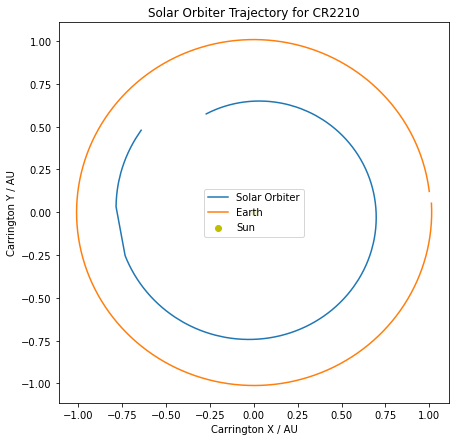

In [31]:
fig, ax = plt.subplots(figsize=(7, 7))
#_ = ax.plot(solo_coords.radius.to("AU")* np.cos(lon_solo*np.pi/180), solo_coords.radius.to("AU")* np.sin(lon_solo*np.pi/180), label="solo")
_ = ax.plot(orbiter.x.to(u.AU), orbiter.y.to(u.AU), label="Solar Orbiter")
#_ = ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), label="omni")
_ = ax.plot(earth_traj.x.to(u.AU), earth_traj.y.to(u.AU), label="Earth")
_ = ax.scatter(0, 0, color="y", label="Sun")


_ = ax.set_xlabel("Carrington X / AU")
_ = ax.set_ylabel("Carrington Y / AU")
_ = ax.legend()
_ = ax.set_title("Solar Orbiter Trajectory for CR2210")
plt.savefig('figures/solo/'+ case_study + '/solo_trajectory_location.png')

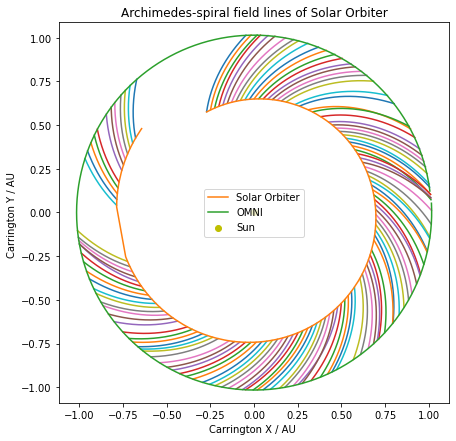

In [32]:
nphi = len(lon_solo)
nrout = 201
earth_mean_r = np.mean(earth_coords.radius.to("AU").value)

fig, ax = plt.subplots(figsize=(7, 7))
for ii in np.arange(0, nphi, 4000):
    phi_location = (lon_solo[ii])*(np.pi/180)
    radial_location = np.linspace(solo_coords.radius.to("AU").value[ii], earth_mean_r, nrout)
    radial_location = radial_location * (u.AU)
    radial_location = radial_location.to(u.km)
    curr_velocity = solo_data.quantity('velocity_0').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 

        x = np.cos(phi_shift_vec)*radial_location.to(u.AU)
        y = np.sin(phi_shift_vec)*radial_location.to(u.AU)

        _ = ax.plot(x[1:], y[1:])

ax.plot(solo_coords.radius.to("AU")* np.cos(lon_solo*np.pi/180), solo_coords.radius.to("AU")* np.sin(lon_solo*np.pi/180), label="Solar Orbiter")
ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), label="OMNI")
ax.scatter(0, 0, color="y", label="Sun")
ax.set_title("Archimedes-spiral field lines of Solar Orbiter")
ax.set_xlabel("Carrington X / AU ")
ax.set_ylabel("Carrington Y / AU ")
plt.axis("equal")
plt.legend()

plt.savefig('figures/solo/'+ case_study + '/Archimedes_spiral_solo.png')

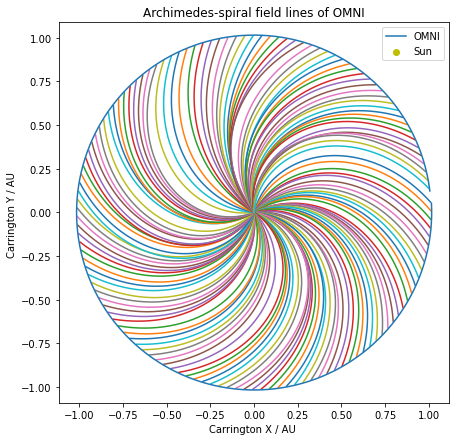

In [33]:
fig, ax = plt.subplots(figsize=(7, 7))
for ii in np.arange(0, len(earth_coords.lon), 5):
    phi_location = (earth_coords.lon.value[ii])*(np.pi/180)
    radial_location = np.linspace(earth_coords.radius.to("AU").value[ii], 0, nrout)
    radial_location = radial_location * (u.AU)
    radial_location = radial_location.to(u.km)
    curr_velocity = omni_data.quantity('V').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 

        x = np.cos(phi_shift_vec)*radial_location.to(u.AU)
        y = np.sin(phi_shift_vec)*radial_location.to(u.AU)

        _ = ax.plot(x[1:], y[1:])

#ax.plot(psp_coords.radius.to("AU")* np.cos(lon_psp*np.pi/180), psp_coords.radius.to("AU")* np.sin(lon_psp*np.pi/180), label="PSP")
ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), label="OMNI")
ax.scatter(0, 0, color="y", label="Sun")
ax.set_title("Archimedes-spiral field lines of OMNI")
ax.set_xlabel("Carrington X / AU ")
ax.set_ylabel("Carrington Y / AU ")
plt.axis("equal")
plt.legend()

plt.savefig('figures/solo/'+ case_study + '/Archimedes_spiral_omni.png')

In [34]:
vr_sampled_hux_f_omni = hux_f_model.sample_at_coords(earth_coords.lon,
                                                     earth_coords.lat,
                                                     earth_coords.radius)

vr_sampled_hux_b_omni = hux_b_model.sample_at_coords(earth_coords.lon,
                                                     earth_coords.lat,
                                                     earth_coords.radius)

vr_sampled_mhd_omni = vr_model.sample_at_coords(earth_coords.lon,
                                                earth_coords.lat,
                                                earth_coords.radius)

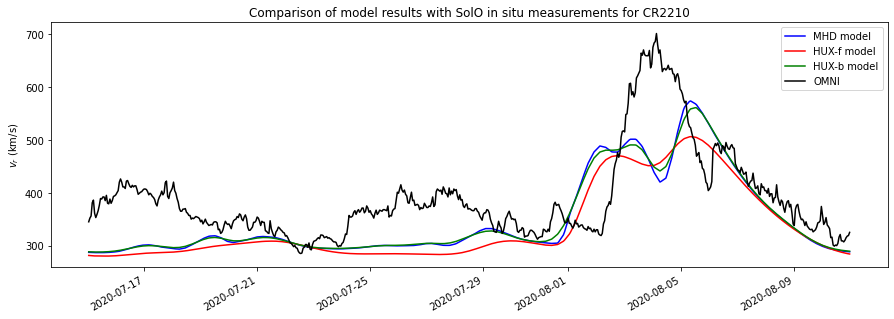

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(omni_data.index, vr_sampled_mhd_omni, color="b", label='MHD model')
ax.plot(omni_data.index, vr_sampled_hux_f_omni, color="r", label='HUX-f model')
ax.plot(omni_data.index, vr_sampled_hux_b_omni, color="g", label='HUX-b model')
ax.plot(omni_data.index, omni_data.quantity('V'),color="k", label='OMNI')

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.legend()
ax.set_title("Comparison of model results with SolO in situ measurements for CR2210")
fig.autofmt_xdate()

plt.savefig('figures/solo/'+ case_study + '/omni_comparison_cr' + str(cr) + '_time.png')

In [36]:
min_index = np.argmin(earth_coords.lon)

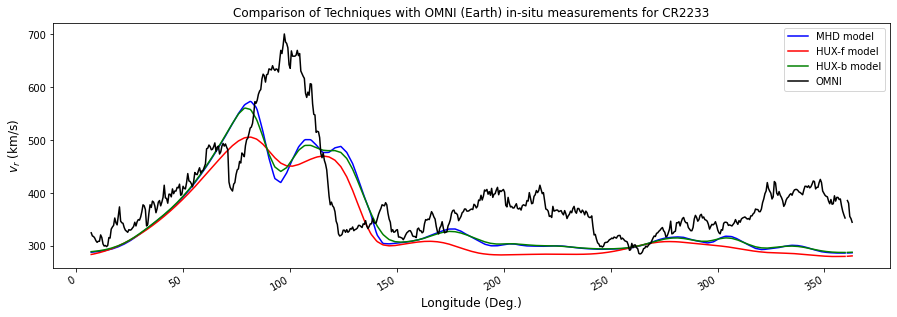

In [37]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_mhd_omni[:min_index], color="b", label="MHD model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_hux_f_omni[:min_index], color="r", label="HUX-f model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_hux_b_omni[:min_index], color="g", label="HUX-b model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, omni_data.quantity('V')[:min_index], color="k", label="OMNI")

ax.plot(earth_coords.lon[min_index+1:], vr_sampled_mhd_omni[min_index+1:], color="b")
ax.plot(earth_coords.lon[min_index+1:], vr_sampled_hux_f_omni[min_index+1:], color="r")
ax.plot(earth_coords.lon[min_index+1:], vr_sampled_hux_b_omni[min_index+1:], color="g")
ax.plot(earth_coords.lon[min_index+1:], omni_data.quantity('V')[min_index+1:], color="k")

ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.legend()
ax.set_title("Comparison of Techniques with OMNI (Earth) in-situ measurements for CR" + str(cr))
fig.autofmt_xdate()


plt.savefig('figures/solo/'+ case_study + '/omni_comparison_cr' + str(cr) + '_lon.png')

# Mapping SolO to OMNI (Earth) using the HUX-f and Ballistic Technique

# Assumptions: 
#### 1.  Latitude is constant in SolO trajectory coordinates 
* Note that HUX is dependent on $\phi$ and $r$ only. 

#### 2. SolO and Earth are aligned in latitude. 
#### 3.  $\phi$ is monotonically increasing - notice that in perihelion 1 psp orbit loops back. 


#### 4. Periodic Boundary Conditions

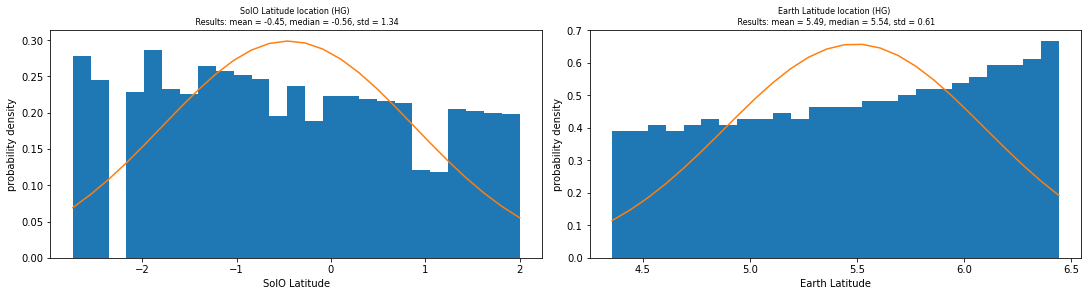

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 4))


## psp latitude trajectory 
mu, sigma = scipy.stats.norm.fit(solo_coords.lat.value)

n , bins, _ = ax[0].hist(solo_coords.lat.value, 25, density=1)
_ = ax[0].set_title("SolO Latitude location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(solo_coords.lat.value), sigma), fontsize=8)
_ = ax[0].set_xlabel("SolO Latitude")
_ = ax[0].set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[0].plot(bins, best_fit_line)


## earth latitude trajectory 
mu, sigma = scipy.stats.norm.fit(earth_traj.coords.lat.value)

n , bins, _ = ax[1].hist(earth_traj.coords.lat.value, 25, density=1)
_ = ax[1].set_title("Earth Latitude location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(earth_traj.coords.lat.value), sigma), fontsize=8)
_ = ax[1].set_xlabel("Earth Latitude")
_ = ax[1].set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[1].plot(bins, best_fit_line)

plt.savefig('figures/solo/'+ case_study + '/solo_earth_lat_traj' + str(cr) + '_lon.png')

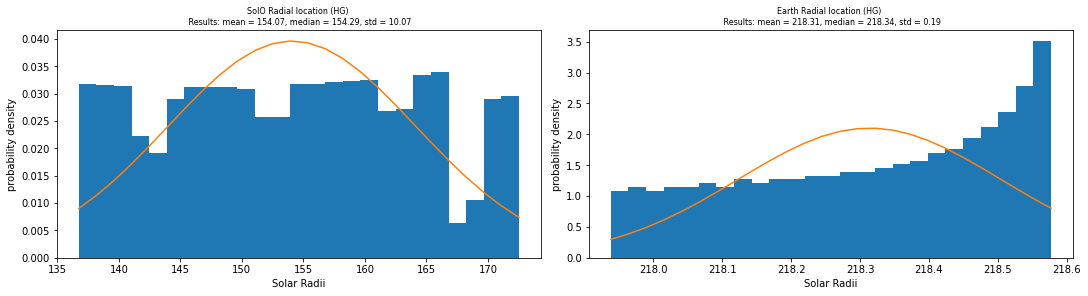

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 4))


## psp radial trajectory 
mu, sigma = scipy.stats.norm.fit(solo_coords.radius.to(u.solRad).value)

n , bins, _ = ax[0].hist(solo_coords.radius.to(u.solRad).value, 25, density=1)
_ = ax[0].set_title("SolO Radial location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(solo_coords.radius.to(u.solRad).value), sigma), fontsize=8)
_ = ax[0].set_xlabel("Solar Radii")
_ = ax[0].set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[0].plot(bins, best_fit_line)


## earth radial trajectory 
mu, sigma = scipy.stats.norm.fit(earth_traj.coords.radius.to(u.solRad).value)

n , bins, _ = ax[1].hist(earth_traj.coords.radius.to(u.solRad).value, 25, density=1)
_ = ax[1].set_title("Earth Radial location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(earth_traj.coords.radius.to(u.solRad).value), sigma), fontsize=8)
_ = ax[1].set_xlabel("Solar Radii")
_ = ax[1].set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[1].plot(bins, best_fit_line)

plt.savefig('figures/solo/'+ case_study + '/solo_earth_rad_traj' + str(cr) + '_lon.png')

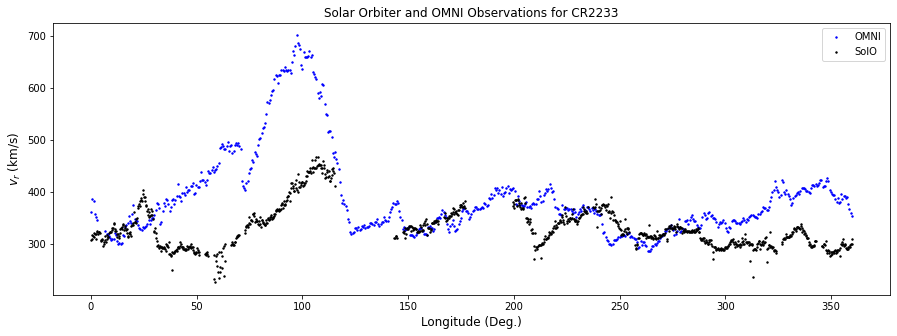

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))

_ = ax.scatter(earth_coords.lon, omni_data.quantity('V'), color="b", s=size, label="OMNI")

_ = ax.scatter(solo_coords.lon[::500], solo_data.quantity('velocity_0')[::500], color="k", s=size, label="SolO")

_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()
_ = ax.set_title("Solar Orbiter and OMNI Observations for CR" + str(cr))
plt.savefig('figures/solo/'+ case_study + '/omni_and_solo_vr_vs_carrington_lon_' + str(cr) +'.png')

# Ballistic Mapping
 * Evaluate the characteristic lines - do they intersect? This happens when the SolO velocity function is decreasing. Otherwise, when the SolO velocity function is increasing it results in rarefaction wave. 
 

In [41]:
r_mean = np.linspace(np.mean(solo_coords.radius), np.mean(earth_coords.radius), 100)
r_min = np.linspace(np.min(solo_coords.radius), np.mean(earth_coords.radius), 100)
r_max = np.linspace(np.max(solo_coords.radius), np.mean(earth_coords.radius), 100)

In [42]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

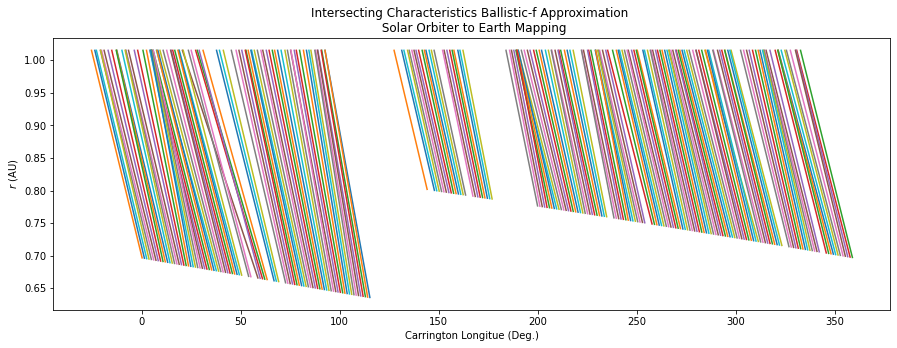

In [43]:
fig, ax = plt.subplots(figsize = (15,5))


for ii in np.arange(0, nphi, 2000):
    phi_location = (lon_solo[ii])*(np.pi/180)
    radial_location = np.linspace(solo_coords.radius.to("AU").value[ii], earth_mean_r, nrout)
    radial_location = radial_location * (u.AU)
    radial_location = radial_location.to(u.km)
    curr_velocity = solo_data.quantity('velocity_0').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 
        _ = ax.plot(phi_shift_vec*(180/np.pi), radial_location.to(u.AU))

_ = ax.set_xlabel("Carrington Longitue (Deg.)")
_ = ax.set_ylabel("$r$ (AU)")
_ = ax.set_title("Intersecting Characteristics Ballistic-f Approximation \n Solar Orbiter to Earth Mapping")
plt.savefig('figures/solo/'+ case_study + '/intersecting_characteristics_ballistic_f' + str(cr) +'.png')

In [44]:
res_ballistic_f = np.zeros(len(np.arange(0, nphi, 1000)))

for jj, ii in enumerate(np.arange(0, nphi, 1000)):
    phi_location = (lon_solo[ii])*(np.pi/180)
    r0 = solo_coords.radius.value[ii]
    rf = earth_mean_r *(u.AU)
    rf = rf.to(u.km).value
    curr_velocity = solo_data.quantity('velocity_0').value[ii]
    dr = rf - r0
    delta_phi = (omega_rot * dr) / curr_velocity
    phi_shifted = phi_location - delta_phi
    # force periodicity
    res_ballistic_f[jj] = phi_shifted % (2 * np.pi)

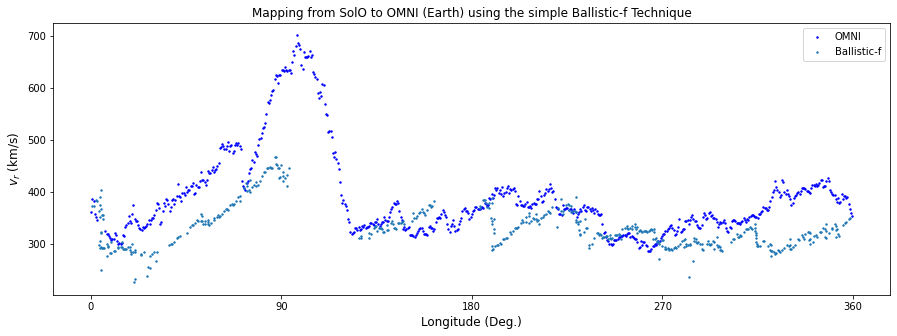

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")

_ = ax.scatter(res_ballistic_f*(180/np.pi), solo_data.quantity('velocity_0')[::1000],s=size, label="Ballistic-f")

_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Mapping from SolO to OMNI (Earth) using the simple Ballistic-f Technique")
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()


# HUX-f Technique
# 1D interpolation - input $\phi$ ranges from [0, 2$\pi$]

In [ ]:
# get longitude limits
min_lon = np.inf
max_lon = -np.inf

for ii in np.arange(0, len(solo_coords.lon.value), 500):
    if solo_coords.lon.value[ii] < min_lon and not math.isnan(solo_data.quantity('velocity_0').value[ii]):
        min_lon = solo_coords.lon.value[ii]
    if solo_coords.lon.value[ii] > max_lon and not math.isnan(solo_data.quantity('velocity_0').value[ii]):
        max_lon = solo_coords.lon.value[ii]

In [ ]:
print("min_lon = ", min_lon)
print("max_lon = ", max_lon)

In [ ]:
# create uniform phi 1d mesh grid. 

phi_array = np.linspace(0, 360, 361)

In [ ]:
# drop NaNs
nan_idx = np.isfinite(solo_data.quantity('velocity_0').value)
v_vec = solo_data.quantity('velocity_0').value[nan_idx]
interp = interpolate.interp1d(solo_coords.lon.value[nan_idx][::500], \
                              v_vec[::500], fill_value=(400, 400),  bounds_error=False)
solo_interp = interp(phi_array)

In [ ]:
# convert to radians
p_hux = phi_array * np.pi/180
# delta phi 
dp_vec_hux = p_hux[1:] - p_hux[:-1]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(phi_array, solo_interp)
ax.scatter(solo_coords.lon.value[::500], solo_data.quantity('velocity_0').value[::500], s=2)

In [ ]:
res_hux_f_min = apply_forward_upwind_model(r_initial=solo_interp,
                                        dr_vec=r_min.value[1:] - r_min.value[:-1],
                                        dp_vec=dp_vec_hux, 
                                        add_v_acc=False, 
                                        r0=r_min[0].value)


res_hux_f_max = apply_forward_upwind_model(r_initial=solo_interp,
                                        dr_vec=r_max.value[1:] - r_max.value[:-1],
                                        dp_vec=dp_vec_hux, 
                                        add_v_acc=False, 
                                        r0=r_max[0].value)


res_hux_f_mean = apply_forward_upwind_model(r_initial=solo_interp,
                                        dr_vec=r_mean.value[1:] - r_mean.value[:-1],
                                        dp_vec=dp_vec_hux, 
                                        add_v_acc=False, 
                                        r0=r_mean[0].value)

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
_ = ax.scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")

_ = ax.plot(phi_array, res_hux_f_mean, color="r", label="HUX-f mean")
_ = ax.plot(phi_array, res_hux_f_min, color="g", label="HUX-f min")
_ = ax.plot(phi_array, res_hux_f_max, color="m", label="HUX-f max")

_ = ax.scatter(res_ballistic_f*(180/np.pi), solo_data.quantity('velocity_0').value[::1000], s=2, c="k", label="Ballistic-f")

_ = ax.set_xlim(np.nanmin(res_ballistic_f*(180/np.pi)), np.nanmax(res_ballistic_f*(180/np.pi)))

_ = ax.set_title("Mapping from Solar Orbiter to OMNI (Earth) for CR" + str(cr)+ "\n $r_{min}$ = %.2f $R_\odot$, $r_{mean}$ = %.2f $R_\odot$, $r_{max}$ = %.2f $R_\odot$" % \
                       (np.min(solo_coords.radius).to(u.solRad).value,
                        np.mean(solo_coords.radius).to(u.solRad).value,
                        np.max(solo_coords.radius).to(u.solRad).value))
                 
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

plt.savefig('figures/solo/'+ case_study + '/solo_to_omni_mapping' + str(cr) + '_lon.png')

# Map OMNI to SolO using the HUX-b and Ballistic Techniques

# Ballistic Mapping
 * evaluate the characteristic lines - do they intersect? This happens when the OMNI velocity function is increasing. Otherwise, when the OMNI velocity function is decreasing it results in rarefaction wave. 
 

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))


for ii in np.arange(0, len(earth_coords.lon), 5):
    phi_location = (earth_coords.lon[ii].value)*(np.pi/180)
    radial_location = np.linspace(earth_coords.radius.to(u.km)[ii], r_min[0].to(u.km), nrout)
    curr_velocity = omni_data.quantity('V').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 
        _ = ax.plot(phi_shift_vec*(180/np.pi), radial_location.to(u.AU))

_ = ax.set_xlabel("Carrington Longitue (Deg.)")
_ = ax.set_ylabel("$r$ (AU)")
_ = ax.set_title("Intersecting Characteristics Ballistic-b Approximation \n Earth to Solar Orbiter Mapping")
plt.savefig('figures/solo/'+ case_study + '/intersecting_characteristics_ballistic_b' + str(cr) +'.png')

# HUX-b Technique

# 1D interpolation - input $\phi$ ranges from [0, 2$\pi$]

In [ ]:
# drop NaNs
nan_idx = np.isfinite(omni_data.quantity('V').value)
v_vec = omni_data.quantity('V').value[nan_idx]
interp = interpolate.interp1d(earth_coords.lon.value[nan_idx], \
                              v_vec, fill_value=(400, 400),  bounds_error=False)
omni_interp = interp(phi_array)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(phi_array, omni_interp)
ax.scatter(earth_coords.lon.value, omni_data.quantity('V').value)

In [ ]:
hux_b_full_res = apply_hux_b_model(r_final=omni_interp, 
                                         dr_vec=r_min.value[1:] - r_min.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_min[0].value, 
                                         add_v_acc=False).T

In [ ]:
points = (phi_array, r_min)
xi = (solo_coords.lon.value, solo_coords.radius.value)
res_hux_b_interp = interpolate.interpn(points, hux_b_full_res, xi)

In [ ]:
ballf = interpolate.interp1d(solo_coords.lon.to(u.rad), solo_coords.radius.to(u.km), fill_value="extrapolate")
solo_r_new = ballf(earth_coords.lon.to(u.rad))

In [ ]:
res_ballistic_b = np.zeros(len(earth_coords.radius))

for ii in range(len(earth_coords.radius)):
    phi_location = (earth_coords.lon[ii].to(u.rad)).value
    r0 = earth_coords.radius.value[ii]
    rf = solo_r_new[ii]
    curr_velocity = omni_data.quantity('V').value[ii]
    dr = rf - r0
    
    delta_phi = (omega_rot * dr) / curr_velocity
    phi_shifted = phi_location - delta_phi
    # force periodicity
    res_ballistic_b[ii] = phi_shifted % (2 * np.pi)

In [ ]:
res_hux_b_min = apply_backwards_upwind_model(r_final=omni_interp, 
                                         dr_vec=r_min.value[1:] - r_min.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_min[0].value, 
                                         add_v_acc=False)

res_hux_b_mean = apply_backwards_upwind_model(r_final=omni_interp, 
                                         dr_vec=r_mean.value[1:] - r_mean.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_mean[0].value, 
                                         add_v_acc=False)

res_hux_b_max = apply_backwards_upwind_model(r_final=omni_interp, 
                                         dr_vec=r_max.value[1:] - r_max.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_max[0].value, 
                                         add_v_acc=False)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.scatter(np.array(solo_coords.lon)[::500], solo_data.quantity('velocity_0')[::500], color="b", s=size, label="OMNI")

_ = ax.scatter(res_ballistic_b*(180/np.pi), omni_data.quantity('V').value, s=2,label="Ballistic-b exact")
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Mapping from OMNI (Earth) to Solar Orbiter using Ballistic-b Technique")
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
_ = ax.scatter(np.array(solo_coords.lon)[::500], solo_data.quantity('velocity_0')[::500], color="b", s=size, label="Solo")

_ = ax.plot(phi_array, res_hux_b_mean, color="r", label="HUX-b mean")
_ = ax.plot(phi_array, res_hux_b_min, color="g", label="HUX-b min")
_ = ax.plot(phi_array, res_hux_b_max, color="m", label="HUX-b max")
_ = ax.scatter(solo_coords.lon.value, res_hux_b_interp, color="k", s=2, label="HUX-b interp")
_ = ax.scatter(res_ballistic_b *(180/np.pi), omni_data.quantity('V').value, color="y", s=2,label="Ballistic-b")


_ = ax.set_title("Mapping from OMNI (Earth) to Solar Orbiter for CR" + str(cr) +"\n $r_{mean}$ = %.2f  $R_\odot$, $r_{min}$ = %.2f  $R_\odot$, $r_{max}$ = %.2f  $R_\odot$" % \
                       (np.min(solo_coords.radius).to(u.solRad).value,
                        np.mean(solo_coords.radius).to(u.solRad).value,
                        np.max(solo_coords.radius).to(u.solRad).value))
                 
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()
plt.savefig('figures/solo/'+ case_study + '/mapping_omni_to_solo' + str(cr) +'.png')

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, constrained_layout=True, sharex=True)

ax[0].set_xlim(0, 360)
ax[0].set_title("Mapping from Solar Orbiter to OMNI (Earth) using HUX-f Technique", fontsize=fs1)
ax[0].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])

ax[0].scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")

ax[0].plot(phi_array, res_hux_f_mean, color="r", label="HUX-f mean Solo $r_{0}$ = "+ 
           str(np.round(np.mean(solo_coords.radius).to(u.solRad), 3)))
ax[0].plot(phi_array, res_hux_f_min, color="g", label="HUX-f min Solo $r_{0}$ = "+ 
            str(np.round(np.min(solo_coords.radius).to(u.solRad), 3)))
ax[0].plot(phi_array, res_hux_f_max, color="m", label="HUX-f max Solo $r_{0}$ = " +
            str(np.round(np.max(solo_coords.radius).to(u.solRad), 3)))
ax[0].legend()


ax[1].set_xlim(0, 360)
ax[1].set_title("Mapping from OMNI (Earth) to Solar Orbiter using HUX-b Technique", fontsize=fs1)
ax[1].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax[1].set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])

ax[1].plot(phi_array, res_hux_b_mean, color="r", label="HUX-b mean Solo $r_{f}$ = "+ 
           str(np.round(np.mean(solo_coords.radius).to(u.solRad), 3)))
ax[1].plot(phi_array, res_hux_b_min, color="g", label="HUX-b min Solo $r_{f}$ = "+ 
            str(np.round(np.min(solo_coords.radius).to(u.solRad), 3)))
ax[1].plot(phi_array, res_hux_b_max, color="m", label="HUX-b max Solo $r_{f}$ = " +
            str(np.round(np.max(solo_coords.radius).to(u.solRad), 3)))
ax[1].scatter(solo_coords.lon.value, res_hux_b_interp, color="y", s=2, label="HUX-b interp")
ax[1].scatter(lon_solo[::500], solo_data.quantity('velocity_0')[::500], color="k", s=size,label="Solo")


ax[1].legend()
plt.savefig('figures/solo/'+ case_study + '/mapping_omni_to_solo_and_back_cr' + str(cr) +'.png')

# Modified HUX Technique to Map non-uniform radial initial condition

In [ ]:
# get longitude limits
min_lon = np.inf
max_lon = -np.inf

for ii in np.arange(0, len(solo_coords.lon.value), 500):
    if solo_coords.lon.value[ii] < min_lon and not math.isnan(solo_data.quantity('velocity_0').value[ii]):
        min_lon = solo_coords.lon.value[ii]
    if solo_coords.lon.value[ii] > max_lon and not math.isnan(solo_data.quantity('velocity_0').value[ii]):
        max_lon = solo_coords.lon.value[ii]
print("min = ", min_lon)
print("max = ", max_lon)
print("closest index min = ")

In [ ]:
min_distance = np.abs(phi_array - min_lon)
max_distance = np.abs(phi_array - max_lon)

In [ ]:
print("closest index min = ", min_distance.argmin())
print("closest index max = ", max_distance.argmin())

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
ax[0].scatter(solo_coords.lon, solo_coords.radius.to(u.AU), s=2)
ax[1].scatter(solo_coords.lon, solo_data.quantity('velocity_0'), s=2, c="r")
ax[1].scatter(phi_array, solo_interp, s=2, c="b")

ax[1].set_xlabel("Longitude (Deg.)")
ax[0].set_ylabel("Radial (AU)")
ax[1].set_ylabel(r'$v_{r}$ (km/s)')

ax[0].set_xlim(min_lon, max_lon)
ax[1].set_xlim(min_lon, max_lon)
ax[0].set_title("SolO Radial Trajectory")
ax[1].set_title("Solo Velocity")

## How to convert the initial radial trajectory to be single-valued?
1. keep the maximum value (will be continious yet does not include the extra propagation). 
2. Keep the minimum value (there will be discontinuities). 
3. linear interpolation maybe?

In [ ]:
# create uniform phi 1d mesh grid. 
max_radial = np.max(solo_coords.radius.to(u.km))
min_radial = np.min(solo_coords.radius.to(u.km))

In [ ]:
# drop NaNs
nan_idx = []

for ii, val in enumerate(solo_coords.radius.to(u.km).value):
    if not math.isnan(val) and not math.isnan(solo_data.quantity('velocity_0').value[ii]):
        nan_idx.append(ii)

In [ ]:
r_vec = solo_coords.radius.to(u.km)[nan_idx]

In [ ]:
# First, lets examine the max-value approach. 
interp_radial = interpolate.interp1d(solo_coords.lon.value[nan_idx], \
                              r_vec, fill_value=(max_radial, (60 * u.solRad).to(u.km)),  kind='nearest-up', bounds_error=False)
solo_r_interp = interp_radial(phi_array)* u.km

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(7, 8))

ax[0].scatter(psp_coords.lon, psp_traj.coords.radius.to(u.solRad), s=2)
ax[1].scatter(phi_array, psp_r_interp.to(u.solRad), s=2)
ax[2].scatter(phi_array, psp_interp, s=2)
ax[2].scatter(psp_coords.lon.value, psp_data.quantity('VR').value, c="r", s=2)
ax[3].plot(psp_coords.lon)


ax[0].set_xlim(min_lon, max_lon)
#ax[1].set_xlim(min_lon, max_lon)
ax[2].set_xlim(min_lon, max_lon)

ax[0].set_title("PSP Radial Trajectory")
ax[1].set_title("PSP Radial Trajectory Interpolated")
ax[2].set_title("PSP $V_{r}$")
ax[3].set_title("PSP Longitude Trajectory (HG)")


ax[0].set_xlabel("Longitude (Deg.)")
ax[1].set_xlabel("Longitude (Deg.)")
ax[2].set_xlabel("Longitude (Deg.)")
ax[3].set_xlabel("index")



ax[0].set_ylabel("$r$ (RS)")
ax[1].set_ylabel("$r$ (RS)")
ax[2].set_ylabel("$v_{r}$ (km/s)")
ax[3].set_ylabel("Longitude (Deg.)")
plt.tight_layout()

The HUX underlying PDE

$$
-\Omega_{rot}\frac{\partial v_{r}}{\partial \phi} + v_{r}\frac{ \partial v_{r}}{\partial r}=0
$$

With the initial condition 
$$
v_{r}(\phi, r_{0}) = v_{r0}(\phi)
$$

If initial conidtion $r_{0}$ is non-uniform then we apply a radial boosting to the standard HUX mapping. Let $r_{psp}(\phi)$ be the radial trajectory of Parker Solar Probe (PSP) spacecraft and $v_{r_{psp}}(\phi)$ be the spacecraft observed solar wind velocity. The radial boosting will modify the initial condition to account for the spacecraft radial location, such that

$$
v_{i + 1, j} = 
\begin{equation} 
    \left\{
    \begin{array}{ll}
          v_{r_{psp}}(\phi_{j}) &  r_{psp}(\phi_{j}) \geq r_{i} \\
          v_{i, j} + \frac{\Delta r\Omega_{\text{rot}}}{\Delta \phi}  (\frac{v_{i, j+1} - v_{i, j}}{v_{i, j}})&  r_{psp}(\phi_{j}) < r_{i} \\
    \end{array} 
    \right. 
\end{equation}
$$

where mesh grid is defined as $r = [\min(r_{psp}), \max(r_{psp})]$ and $\phi = [0, 2\pi]$. The indexes $i$ and $j$ denote the radial ($r$) and longitude ($\phi$) grid indexing, respectively. After applying the radial boost, the initial condition is the velocity propagated up to $r_{\max} = \max(r_{psp})$. Then, we propagate from $r_{\max}$ out radially using the standard Heliospheric Upwind eXtrapolation Technique (HUX). 

In [ ]:
mod_v = forward_radial_boosting(r_vec=psp_r_interp.value, v_vec=psp_interp, p_vec=phi_array*np.pi/180, nr=30)

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols= 1, sharex=True, figsize=(10, 7))
ax[0].scatter(phi_array, psp_interp, c="b", label="psp", s=2)
ax[0].scatter(phi_array, mod_v, c="r", label="psp-mod", s=2)
ax[1].scatter(phi_array, psp_r_interp.to(u.solRad), s=1)
ax[2].scatter(phi_array, mod_v-psp_interp, s=2)
_ = ax[0].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
#_ = ax[0].set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax[1].set_ylabel("$r$ (RS)", fontsize=fs1)
#_ = ax[1].set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax[2].set_ylabel("$v_{ic} - v_{r_{0}}$", fontsize=fs1)
_ = ax[2].set_xlabel("Longitude (Deg.)", fontsize=fs1)


_ = ax[0].set_title('difference between initial conditions', fontsize=fs1)
_ = ax[1].set_title("PSP Radial Trajectory", fontsize=fs1)
_ = ax[2].set_title("modified initial condition - messurements", fontsize=fs1)
_ = ax[0].legend()
plt.tight_layout()

In [ ]:
res_hux_f_mod = apply_forward_upwind_model(r_initial=mod_v,
                                        dr_vec=r_max.value[1:] - r_max.value[:-1],
                                        dp_vec=dp_vec_hux, 
                                        add_v_acc=False, 
                                        r0=r_max[0].value)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")

_ = ax.plot(phi_array, res_hux_f_mean, color="r", label="HUX-f mean")
_ = ax.plot(phi_array, res_hux_f_min, color="g", label="HUX-f min")
_ = ax.plot(phi_array, res_hux_f_max, color="m", label="HUX-f max")
_ = ax.plot(phi_array, res_hux_f_mod, color="k", label="HUX-f modified")


_ = ax.scatter(res_ballistic_f*(180/np.pi), psp_data.quantity('VR'),s=2, label="Ballistic-f")

_ = ax.set_xlim(np.nanmin(res_ballistic_f)*(180/np.pi), np.nanmax(res_ballistic_f)*(180/np.pi))

_ = ax.set_title("Mapping from PSP to OMNI (Earth) using HUX-f Technique \n mean = %.2f, min = %.2f, max = %.2f" % \
                       (np.min(psp_coords.radius).to(u.solRad).value,
                        np.mean(psp_coords.radius).to(u.solRad).value,
                        np.max(psp_coords.radius).to(u.solRad).value))
                 
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

# Modified HUX-b to final velocity being in PSP radial trajectory.

First, we map OMNI messurements to $\max(r_{psp})$. Then we add an extra radial boost. This should work well in comparison to the modified HUX-f Technique since the messurements at OMNI cover the periodic longitude axis (HG) and therefore the initial condition is not extrapolated. 

Let $r_{psp}(\phi)$ be the radial trajectory of Parker Solar Probe (PSP) spacecraft and $v_{r_{psp}}(\phi)$ be PSP observed solar wind velocity. The radial boosting will modify the final velocity at PSP to account for the spacecraft radial location, such that

$$
v_{i + 1, j} = 
\begin{equation} 
    \left\{
    \begin{array}{ll}
          v_{i, j} &  r_{psp}(\phi_{j}) < r_{i} \\
          v_{i, j} + \frac{\Delta r\Omega_{\text{rot}}}{\Delta \phi}  (\frac{v_{i, j-1} - v_{i, j}}{v_{i, j}})&  r_{psp}(\phi_{j}) > r_{i} \\
    \end{array} 
    \right. 
\end{equation}
$$

where the mesh grid is defined as $r = [\min(r_{psp}), \max(r_{psp})]$ and $\phi = [0, 2\pi]$. The indexes $i$ and $j$ denote the radial ($r$) and longitude ($\phi$) grid indexing, respectively. This radial boost is applied after the standard HUX technqiue maps solar wind streams from OMNI (Earth) to $\max(r_{psp})$.

In [ ]:
res_hux_b_mod = backwards_radial_boosting(r_vec=psp_r_interp.value, 
                                          v_vec=res_hux_b_max, 
                                          p_vec=phi_array*np.pi/180, 
                                          nr=30)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.scatter(np.array(psp_coords.lon), psp_data.quantity('VR'), color="b", s=size, label="PSP")

_ = ax.plot(phi_array, res_hux_b_mean, color="r", label="HUX-b mean")
_ = ax.plot(phi_array, res_hux_b_min, color="g", label="HUX-b min")
_ = ax.plot(phi_array, res_hux_b_max, color="m", label="HUX-b max")
_ = ax.plot(phi_array, res_hux_b_mod, color="k", label="HUX-b mod")
_ = ax.plot(psp_coords.lon.value, res_hux_b_interp, color="y", label="HUX-b interp")



_ = ax.scatter(res_ballistic_b_max, omni_data.quantity('V'),  color="m", s=2, label="Ballistic-b max")
_ = ax.scatter(res_ballistic_b_mean, omni_data.quantity('V'),  color="r", s=2,label="Ballistic-b mean")
_ = ax.scatter(res_ballistic_b_min, omni_data.quantity('V').value, color="g",  s=2,label="Ballistic-b min")

_ = ax.set_title("Mapping from OMNI (Earth) to PSP using HUX-b Technique \n min = %.2f $R_\odot$, mean = %.2f $R_\odot$, max = %.2f $R_\odot$" % \
                       (np.min(psp_coords.radius).to(u.solRad).value,
                        np.mean(psp_coords.radius).to(u.solRad).value,
                        np.max(psp_coords.radius).to(u.solRad).value))
                 
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols= 1, sharex=True, figsize=(10, 7))
ax[0].scatter(phi_array, res_hux_b_max, c="b", label="v-max", s=2)
ax[0].scatter(phi_array, res_hux_b_min, c="g", label="v-min", s=2)
ax[0].scatter(phi_array, res_hux_b_mod, c="r", label="v-mod", s=2)
ax[0].scatter(psp_coords.lon.value, res_hux_b_interp, color="y", s=2, label="v-interp")
ax[1].scatter(phi_array, psp_r_interp.to(u.solRad), s=1)
ax[2].scatter(phi_array, res_hux_b_mod- res_hux_b_min, s=2)
_ = ax[0].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax[1].set_ylabel("$r$ (RS)", fontsize=fs1)
_ = ax[2].set_ylabel("$v_{mod} - v_{min}$", fontsize=fs1)
_ = ax[2].set_xlabel("Longitude (Deg.)", fontsize=fs1)


_ = ax[0].set_title('$v_{f}$', fontsize=fs1)
_ = ax[1].set_title("PSP Radial Trajectory", fontsize=fs1)
_ = ax[2].set_title("modified $v_{f}$ - min $v_{f}$", fontsize=fs1)
_ = ax[0].legend()
plt.tight_layout()

### Propagated Error of HUX-f for Solo in-situ  velocity 

![](figures/literature/hux-stencil.PNG)

In [ ]:
print("closest index min = ", min_distance.argmin())
print("closest index max = ", max_distance.argmin())

Assume we have $m$ mesh points in $\phi$ grid and $n$ mesh points in $r$ grid. Since PSP does not cover the full Sun latitude in HG coordinates, we extrapolate the velocity profile at PSP. In order to examine the propaged error from such extrapolation, we evaluate the forward sencil on the given $\phi/r$ mesh grid.  


For forward propagation, it is visible from the upwind stencil that error is propagated from the east. Let the longitude axis be a modest uniform mesh $\Delta \phi = 1  ^{\circ}$ where $m= 360$, and the radial axis have 100 mesh points, meaning $\Delta r = 1.102 R_\odot$ In the case of PSP perihelion 1 (P1), we are able to gather the solar wind stream radial speed from $216^{\circ}$ to $336^{\circ}$ in longitude (HG coordinates). Consequently, when mapping to 1 AU (Earth) the indices between [336, 360] and [0, 216] can contribute to the propagated error. 

Therefore the value at index 336 will contribute to the value at index $336-100 = 236$ after propagation. 
